In [2]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
%matplotlib inline

# 查看数据

In [3]:
fold_path = './data/'
train_transaction = pd.read_csv(f'{fold_path}train_transaction.csv')
test_transaction = pd.read_csv(f'{fold_path}test_transaction.csv')
train_identity = pd.read_csv(f'{fold_path}train_identity.csv')
test_identity = pd.read_csv(f'{fold_path}test_identity.csv')

print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [4]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [8]:
# list(train_transaction.columns)
# list(test_identity.columns)
# len(list(train.columns)) # 434

In [102]:
print(train_transaction['TransactionID'].isin(train_identity['TransactionID']).sum())
print(test_transaction['TransactionID'].isin(test_identity['TransactionID']).sum())

144233
141907


**正负样本占比**

In [103]:
print('{:.2f}% of Transactions are fraud'.format(train_transaction['isFraud'].mean()*100))

3.50% of Transactions are fraud


**合并train_trasaction和test_transaction**

In [9]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [10]:
del train_transaction, train_identity, test_transaction, test_identity

**各列缺失值情况**

In [17]:
print('There are {0} columns in train dataset are null and the number of all columns is {1}'.format(
    train.isnull().any().sum(), len(list(train.columns))))

There are 414 columns in train dataset are null and the number of all columns is 434


**只有单一值的特征**

In [19]:
one_value_col_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_col_test = [col for col in test.columns if test[col].nunique() <= 1]

In [20]:
print('Features that only have one value in train')
print(one_value_col_train)
print('Features that only have one value in test')
print(one_value_col_test)

Features that only have one value in train
[]
Features that only have one value in test
['V107']


In [22]:
# train['V107'].value_counts()

# 数据探索

**TransactionDT是时间序列，查看训练集和测试集的时间分布**

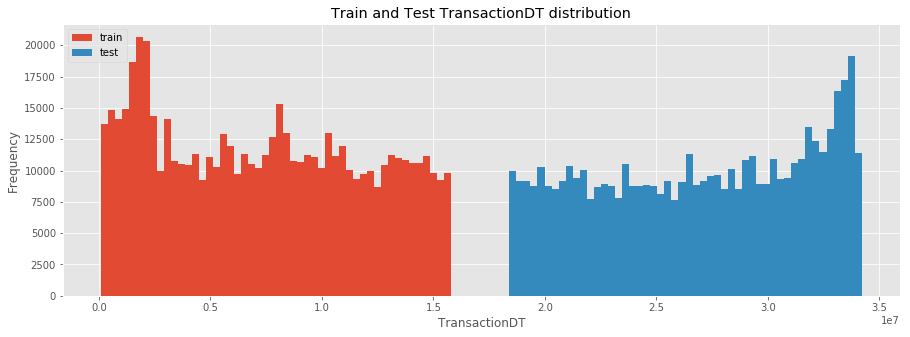

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.hist(train['TransactionDT'], bins=50, label='train')
plt.hist(test['TransactionDT'], bins=50, label='test')
plt.title('Train and Test TransactionDT distribution')
plt.xlabel('TransactionDT')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## 交易信息

**查看交易金额**

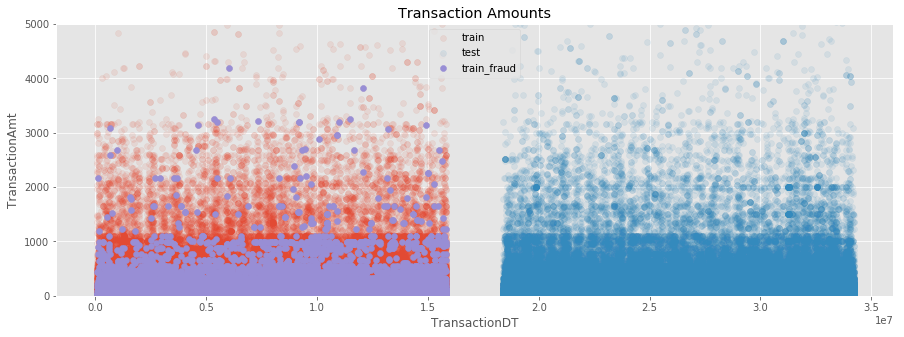

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.scatter(x=train['TransactionDT'], y=train['TransactionAmt'],
            alpha=0.1, color=color_pal[0], label='train')
plt.scatter(x=test['TransactionDT'], y=test['TransactionAmt'],
            alpha=0.1, color=color_pal[1], label='test')
plt.scatter(x=train[train['isFraud'] == 1].TransactionDT,
            y=train[train['isFraud'] == 1].TransactionAmt,
            color=color_pal[2], label='train_fraud')
plt.title('Transaction Amounts')
plt.xlabel('TransactionDT')
plt.ylabel('TransactionAmt')
plt.legend()
plt.ylim(0, 5000)
plt.show()

**交易金额分布**

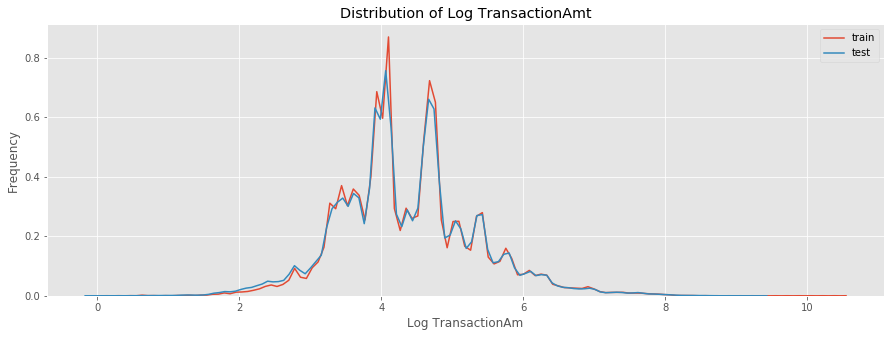

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.kdeplot(np.log1p(train['TransactionAmt']), label='train')
sns.kdeplot(np.log1p(test['TransactionAmt']), label='test')
plt.title('Distribution of Log TransactionAmt')
plt.xlabel('Log TransactionAm')
plt.ylabel('Frequency')
plt.legend()
plt.show()

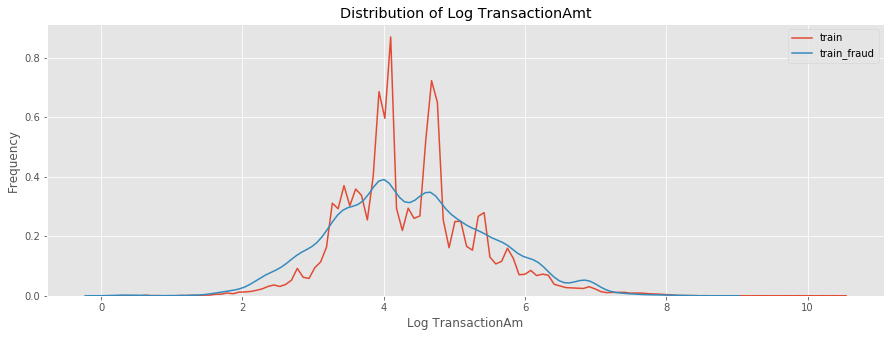

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.kdeplot(np.log1p(train['TransactionAmt']), label='train')
sns.kdeplot(np.log1p(train[train['isFraud'] == 1].TransactionAmt), label='train_fraud')
plt.title('Distribution of Log TransactionAmt')
plt.xlabel('Log TransactionAm')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**ProductCD**

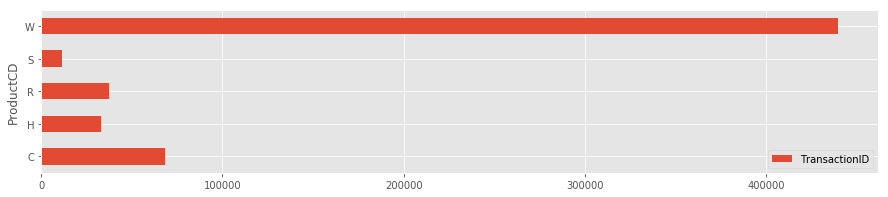

In [28]:
train.groupby('ProductCD').agg({'TransactionID':'count'}).plot(kind='barh', figsize=(15, 3))
plt.show()

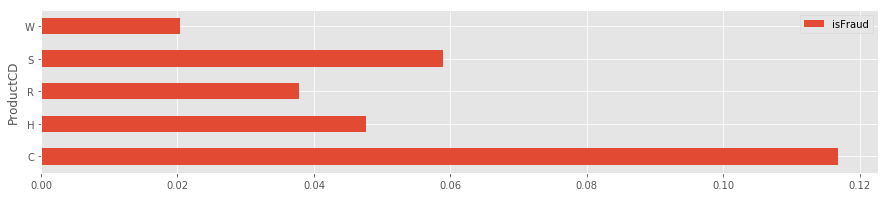

In [31]:
train.groupby('ProductCD').agg({'isFraud':'mean'}).plot(kind='barh', figsize=(15, 3))
plt.show()

**card1-card6**

In [32]:
card_cols = ['card'+str(i) for i in range(1, 7)]
train[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


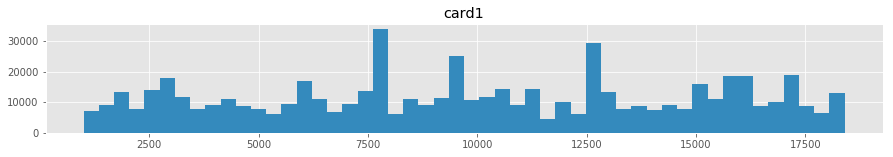

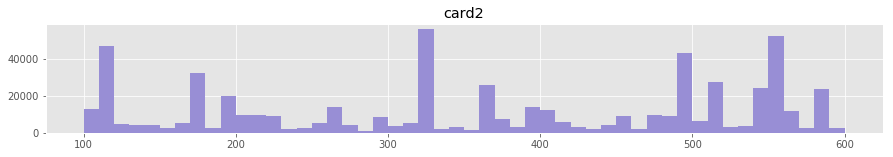

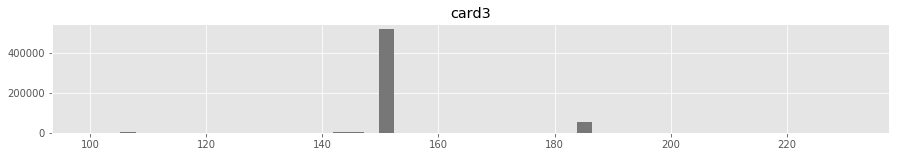

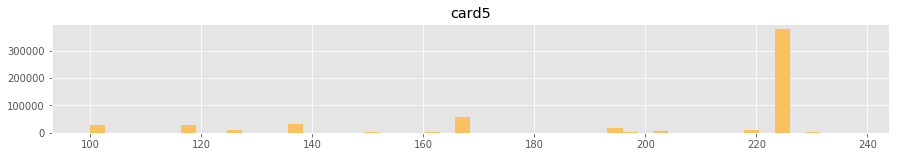

In [34]:
i = 1
for col in card_cols:
    if train[col].dtype in ['float64', 'int64']:
        plt.figure(figsize=(15, 2))
        plt.hist(train[col].dropna(), bins=50, color=color_pal[i])
        plt.title(col)
        plt.show()
        i += 1

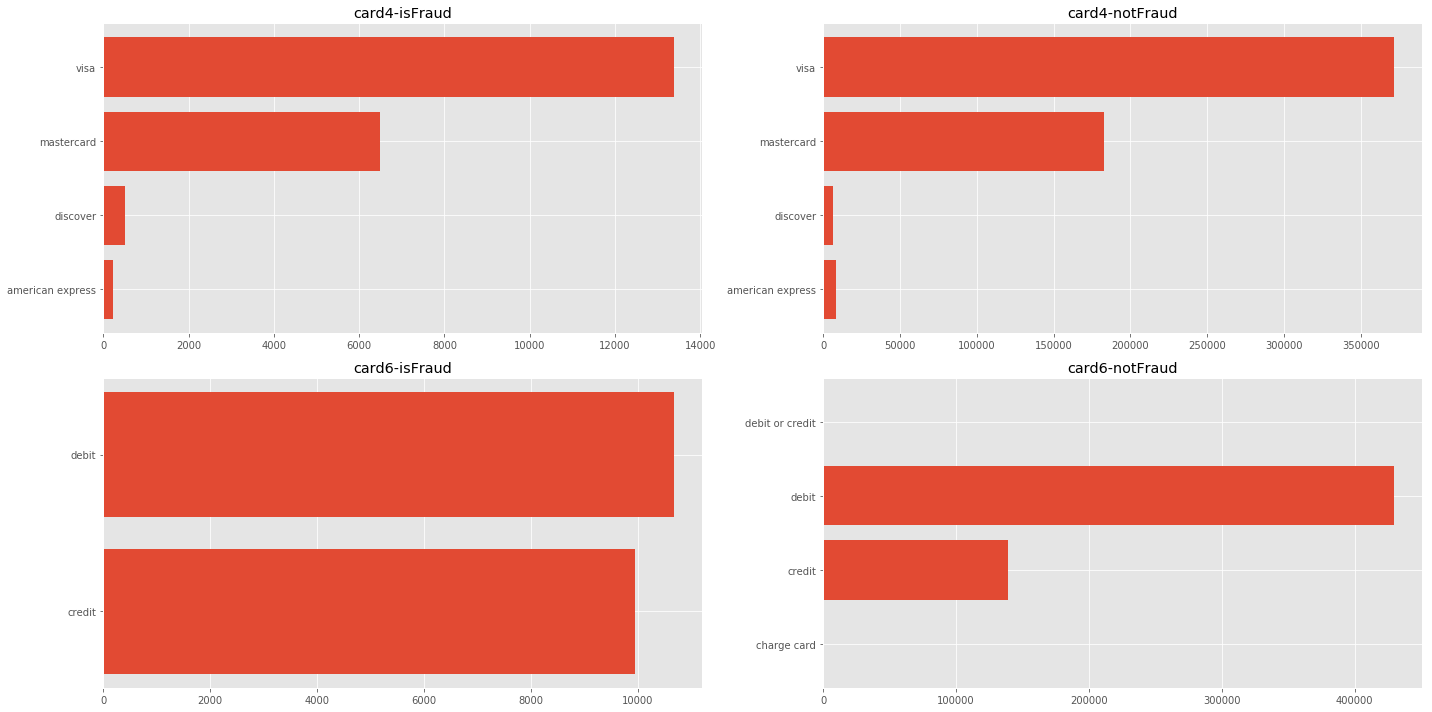

In [36]:
train_fraud = train[train['isFraud'] == 1]
train_notfraud = train[train['isFraud'] == 0]

fig, axes = plt.subplots(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.barh(y=train_fraud.groupby('card4').agg({'isFraud': 'count'}).reset_index(
).card4, width=train_fraud.groupby('card4').agg({'isFraud': 'count'}).reset_index().isFraud)
plt.title('card4-isFraud')
plt.subplot(2, 2, 2)
plt.barh(y=train_notfraud.groupby('card4').agg({'isFraud': 'count'}).reset_index(
).card4, width=train_notfraud.groupby('card4').agg({'isFraud': 'count'}).reset_index().isFraud)
plt.title('card4-notFraud')
plt.subplot(2, 2, 3)
plt.barh(y=train_fraud.groupby('card6').agg({'isFraud': 'count'}).reset_index(
).card6, width=train_fraud.groupby('card6').agg({'isFraud': 'count'}).reset_index().isFraud)
plt.title('card6-isFraud')
plt.subplot(2, 2, 4)
plt.barh(y=train_notfraud.groupby('card6').agg({'isFraud': 'count'}).reset_index(
).card6, width=train_notfraud.groupby('card6').agg({'isFraud': 'count'}).reset_index().isFraud)
plt.title('card6-notFraud')
plt.tight_layout()

**addr1&addr2**

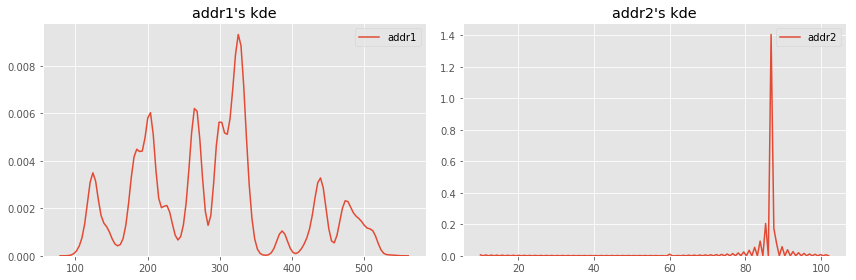

In [37]:
plt.subplots(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(train['addr1'])
plt.title('addr1\'s kde')
plt.subplot(1, 2, 2)
sns.kdeplot(train['addr2'])
plt.title('addr2\'s kde')
plt.tight_layout()
plt.show()

**dist1&dist2**

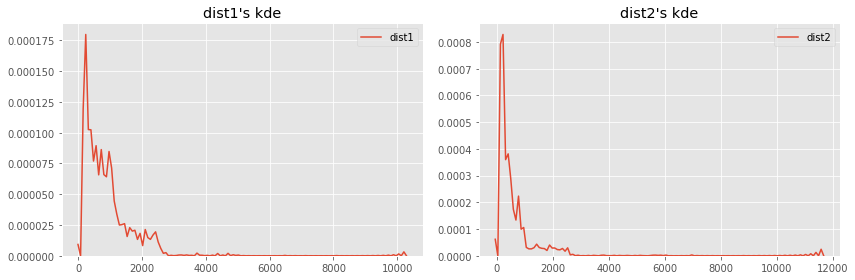

In [178]:
plt.subplots(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(train_transaction['dist1'])
plt.title('dist1\'s kde')
plt.subplot(1, 2, 2)
sns.kdeplot(train_transaction['dist2'])
plt.title('dist2\'s kde')
plt.tight_layout()
plt.show()

**C1-C14**

In [38]:
c_cols = ['C'+str(i) for i in range(1, 15)]
train[c_cols].head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


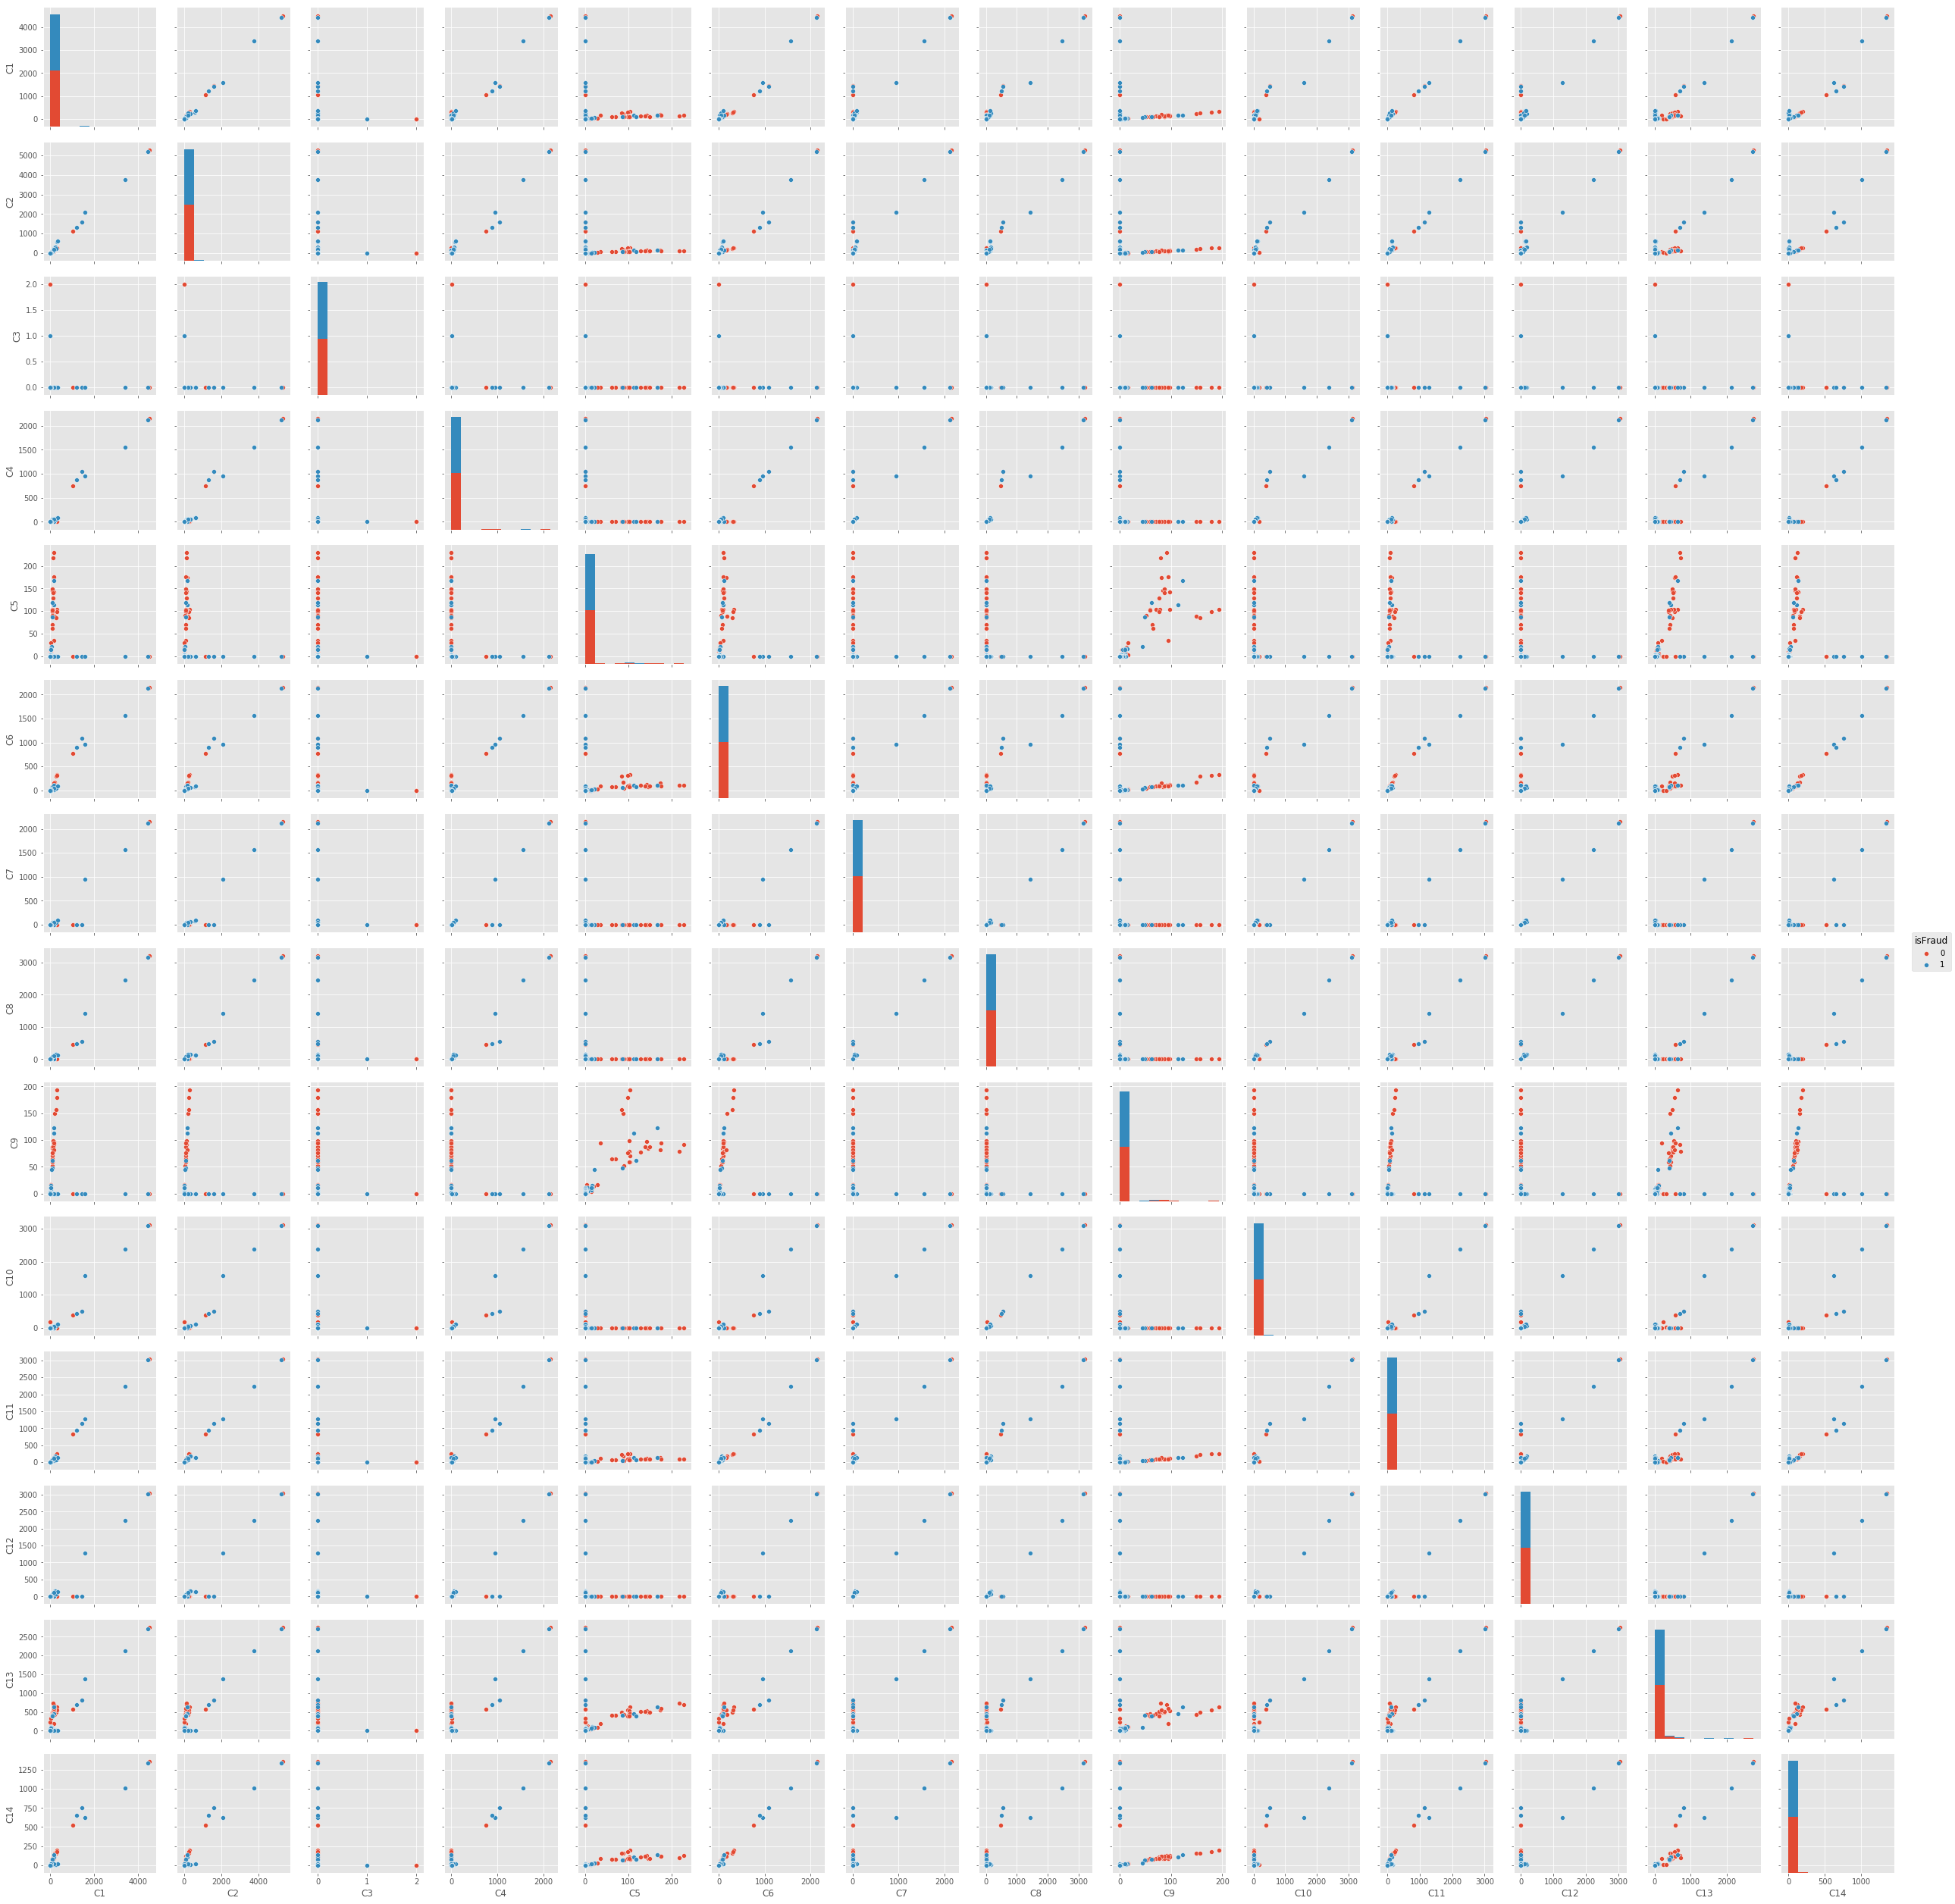

In [39]:
sampled_train = pd.concat([train.loc[train['isFraud'] == 0].sample(500),
                           train.loc[train['isFraud'] == 1].sample(500)])

sns.pairplot(sampled_train,
             hue='isFraud',
             vars=c_cols)
plt.show()

**D1-D19**

In [50]:
d_cols = [c for c in train.columns if c[0] == 'D' and c not in ['DeviceType', 'DeviceInfo']]
train[d_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


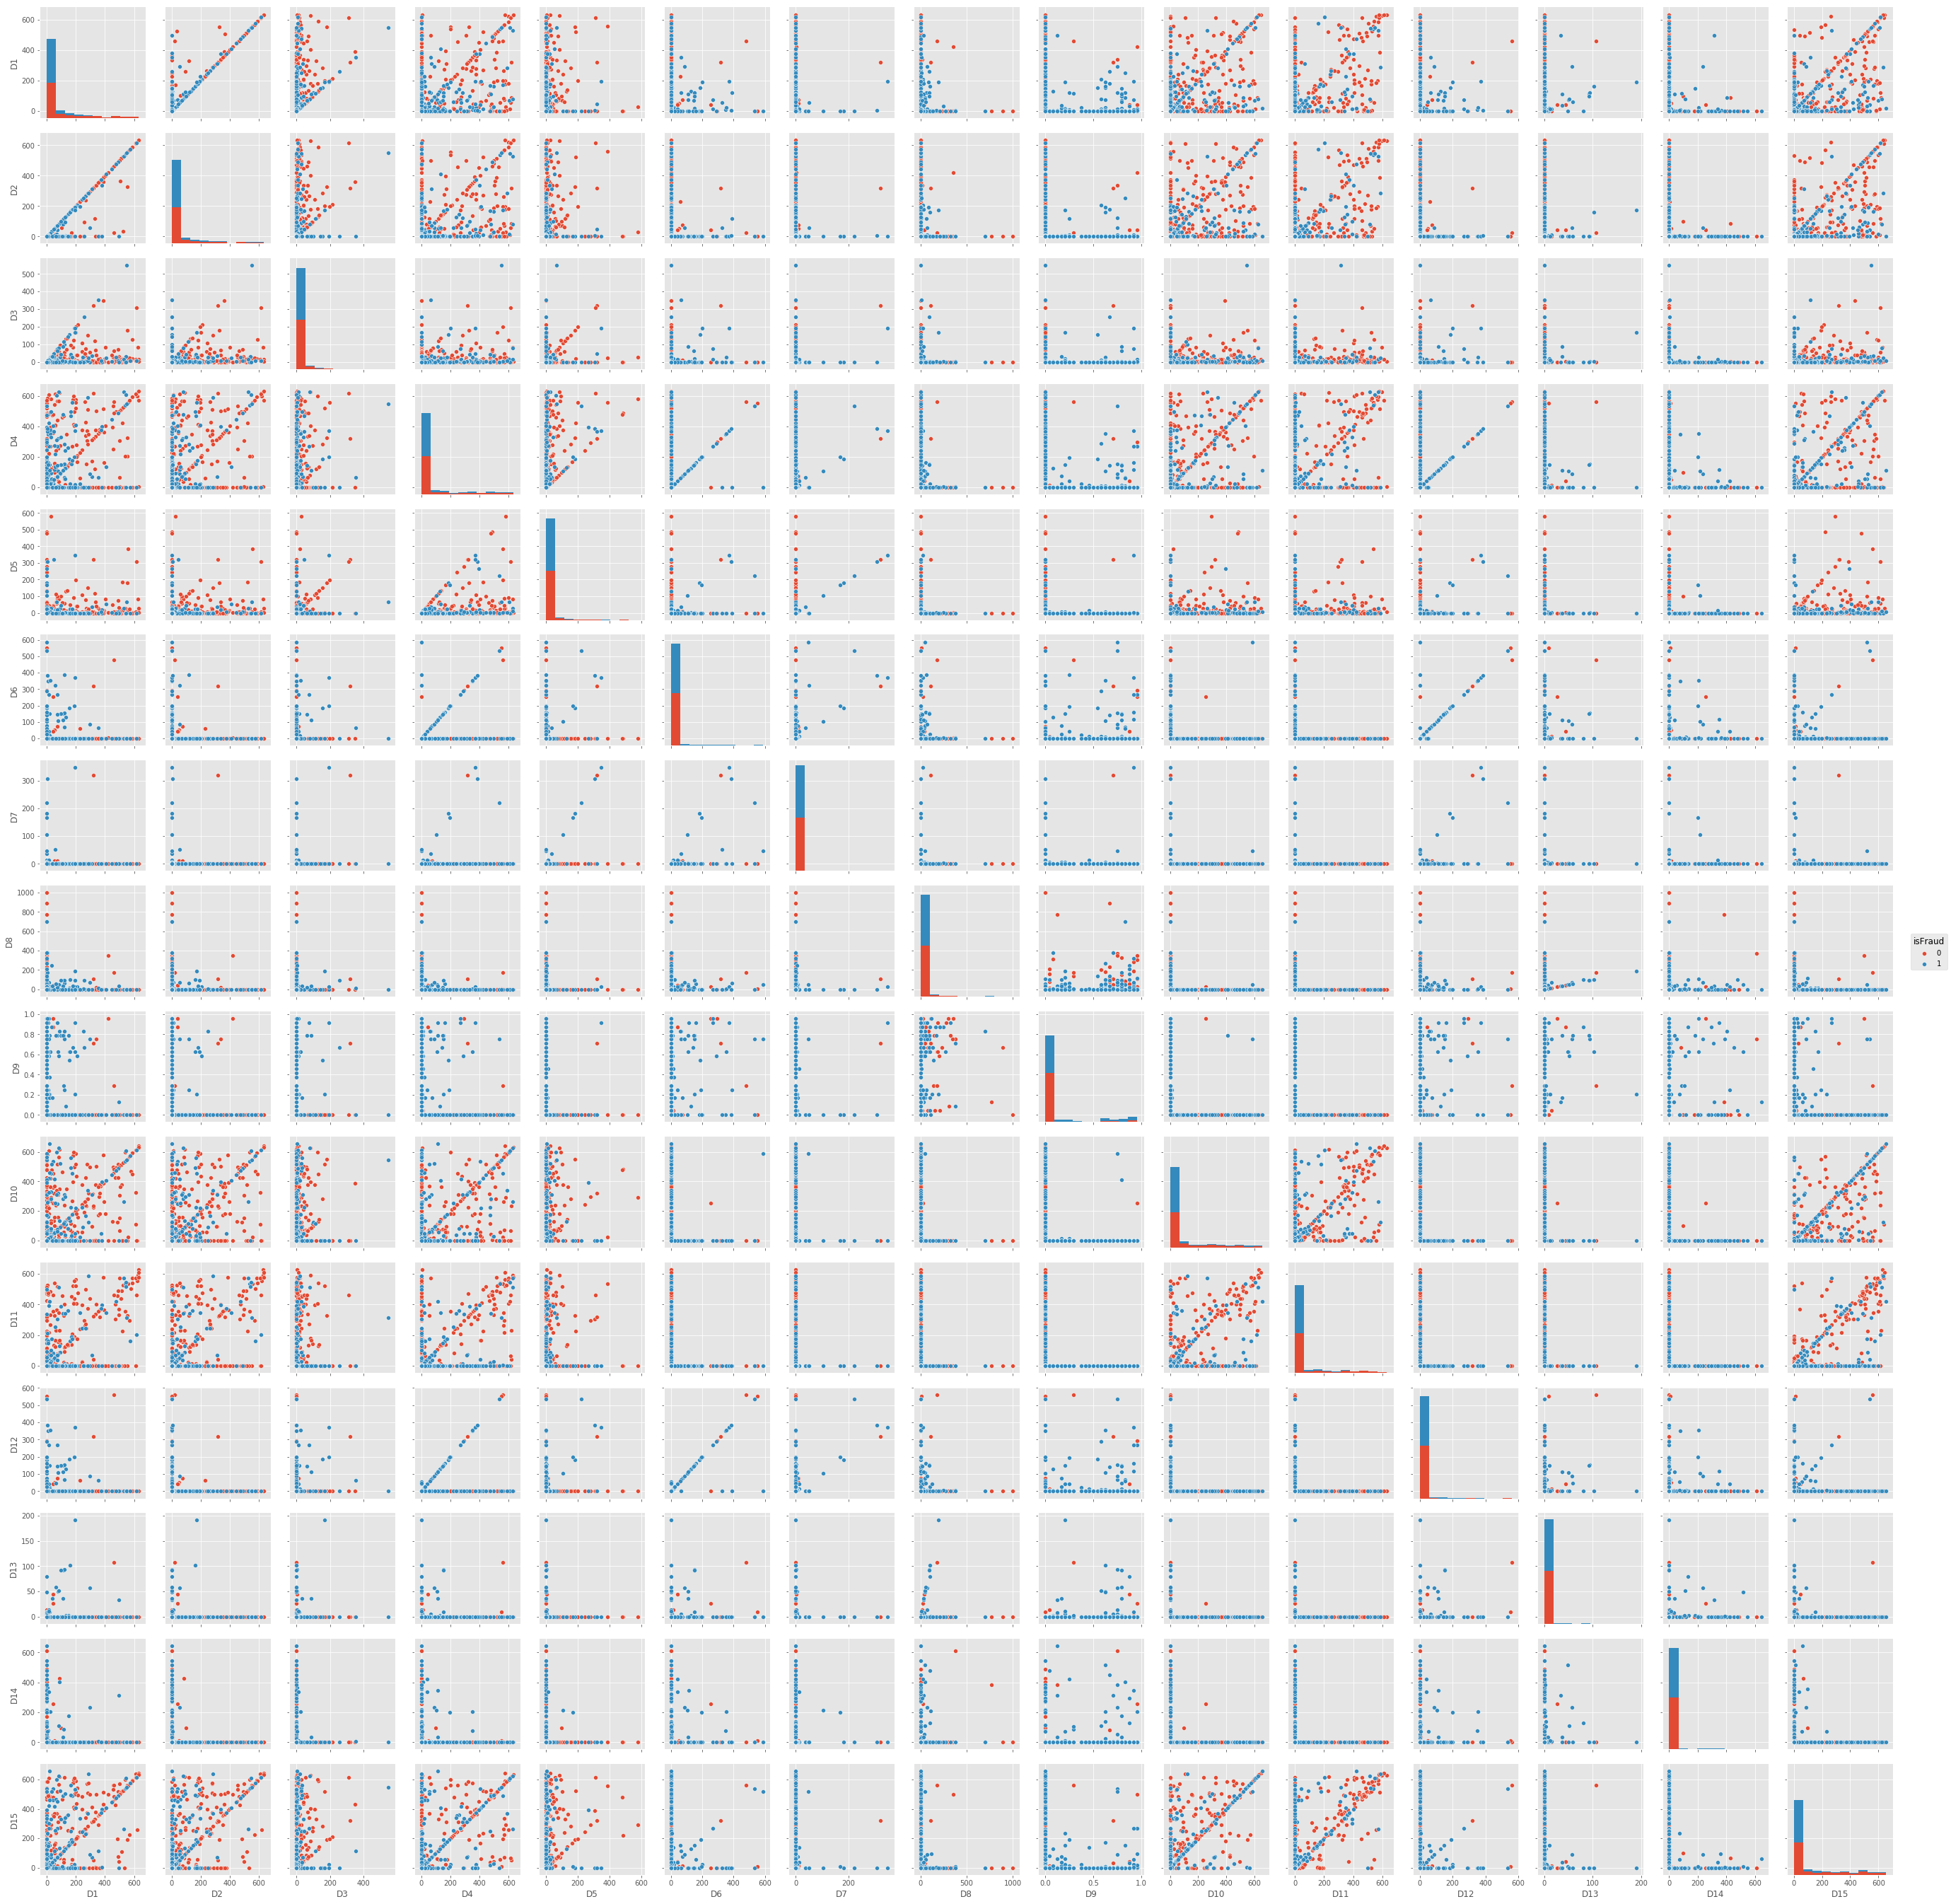

In [51]:
sampled_train = pd.concat([train.loc[train['isFraud'] == 0].sample(500),
                           train.loc[train['isFraud'] == 1].sample(500)])
sns.pairplot(sampled_train.fillna(0), 
             hue='isFraud',
            vars=d_cols)
plt.show()

**M1-M19**

In [52]:
m_cols = [c for c in train.columns if c[0] == 'M']
train[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


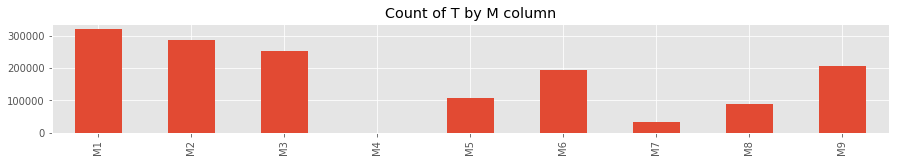

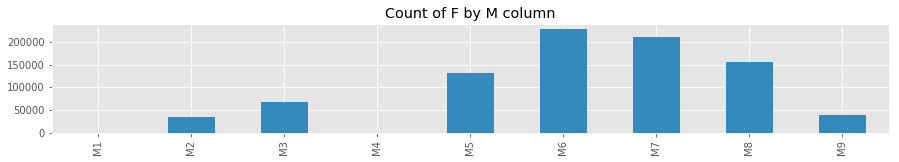

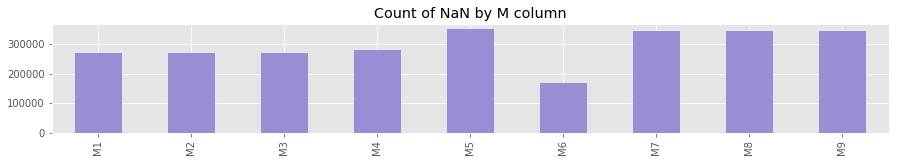

In [71]:
(train[m_cols] == 'T').sum().plot(kind='bar',
                                  title='Count of T by M column',
                                  figsize=(15, 2),
                                  color=color_pal[0])
plt.show()
(train[m_cols] == 'F').sum().plot(kind='bar',
                                  title='Count of F by M column',
                                  figsize=(15, 2),
                                  color=color_pal[1])
plt.show()
(train[m_cols].isna()).sum().plot(kind='bar',
                                  title='Count of NaN by M column',
                                  figsize=(15, 2),
                                  color=color_pal[2])
plt.show()

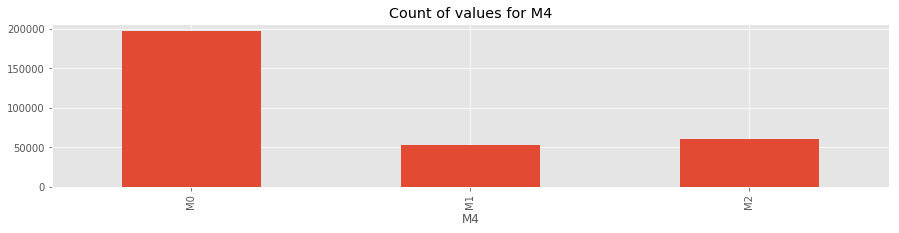

In [73]:
train.groupby('M4')['TransactionID'].count().plot(
    kind='bar', title='Count of values for M4', figsize=(15, 3))
plt.show()

**V1-V339**

In [53]:
v_cols = [c for c in train.columns if c[0] == 'V']
train[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
train[v_cols].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.072870,1.027704,1.041529,0.463915,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,0.007390,0.240133,0.320890,0.440053,0.475902,0.239385,0.304779,0.186069,0.226339,0.521522,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,8.000000,9.000000,6.000000,6.000000,9.000000,9.000000,8.000000,8.000000,4.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


## 用户身份信息

**DeviceType&DeviceInfo**

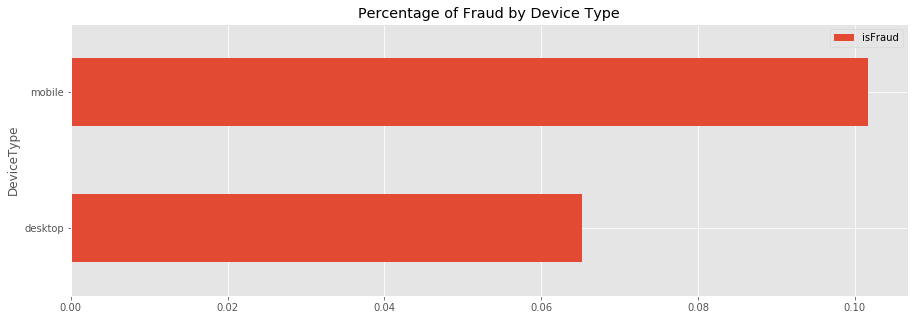

In [78]:
train.groupby('DeviceType').agg({'isFraud':'mean'}).plot(
    kind='barh', figsize=(15, 5), title='Percentage of Fraud by Device Type')
plt.show()

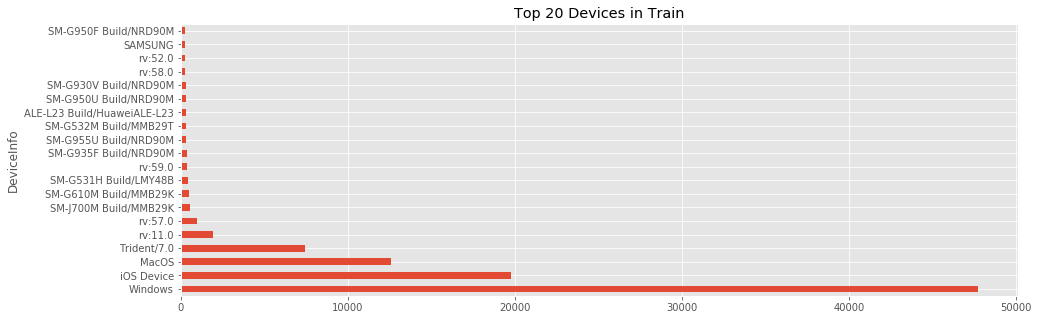

In [80]:
train.groupby('DeviceInfo').count()['TransactionID'].sort_values(
    ascending=False).head(20).plot(kind='barh', figsize=(15, 5), title='Top 20 Devices in Train')
plt.show()

**id_01-id_11**

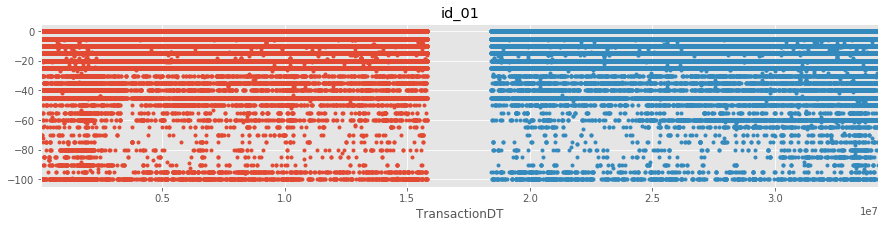

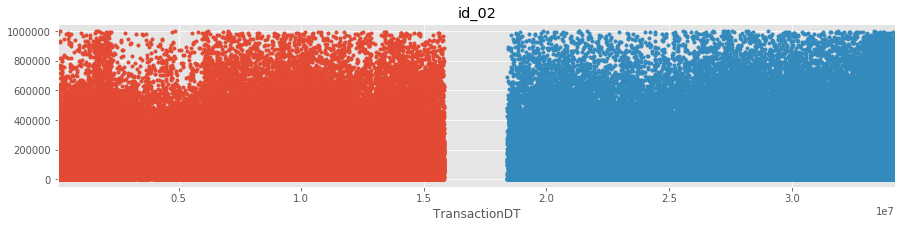

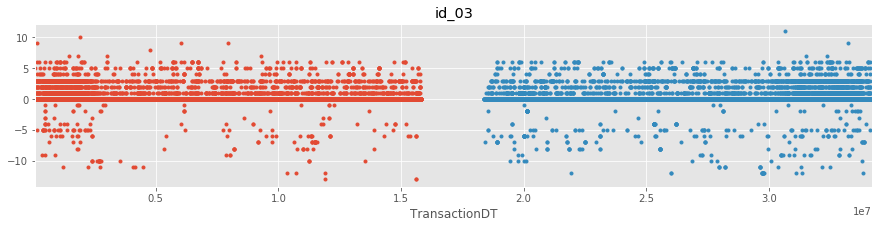

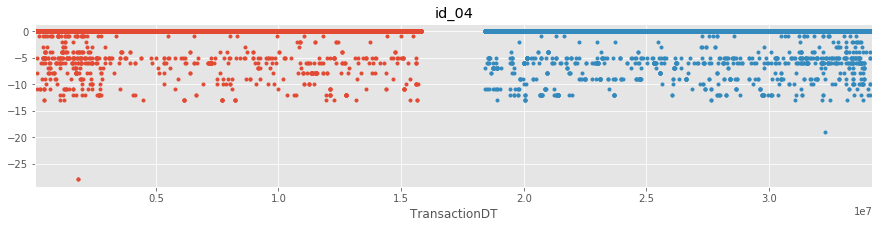

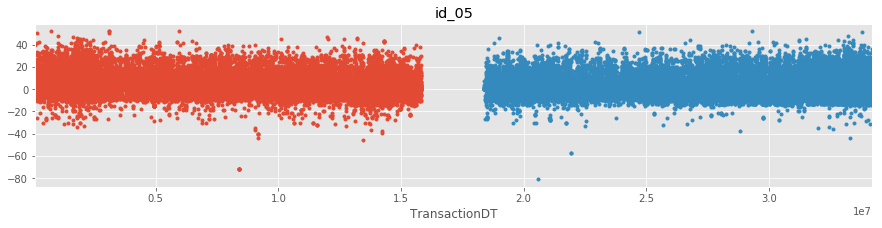

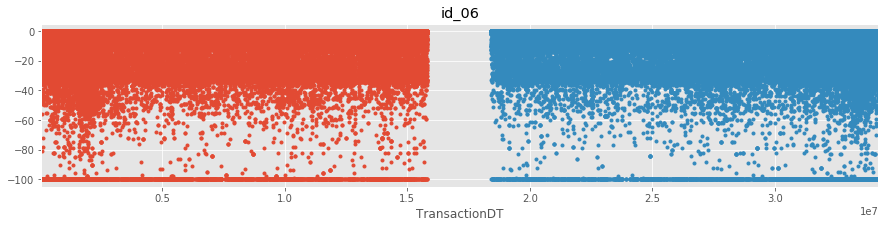

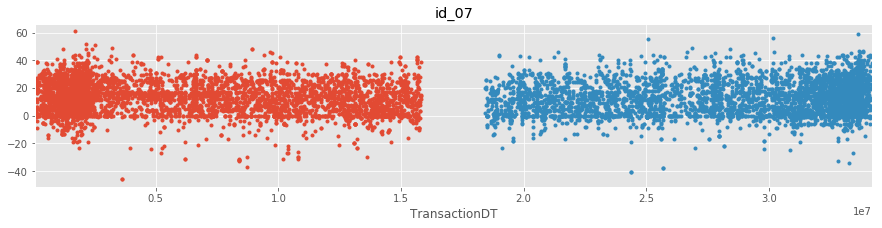

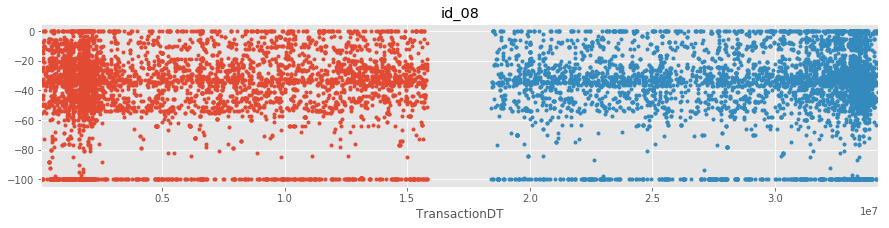

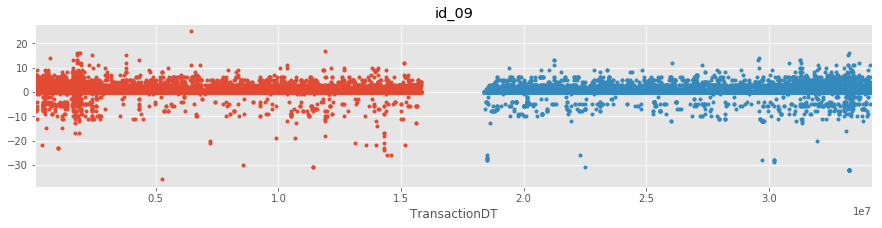

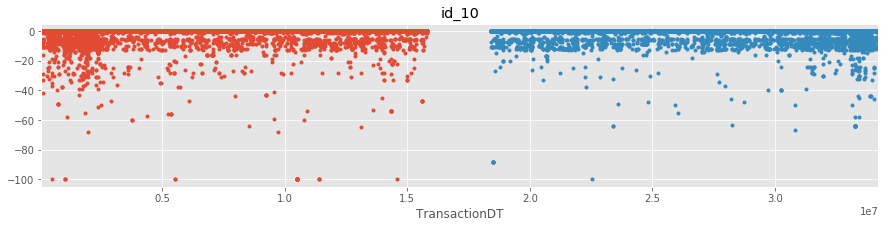

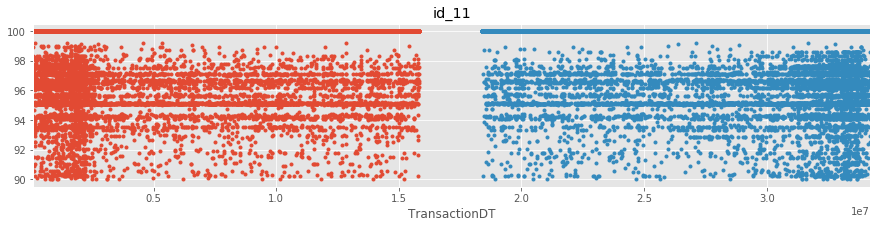

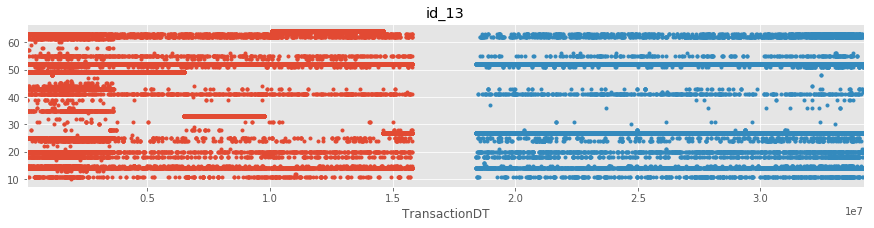

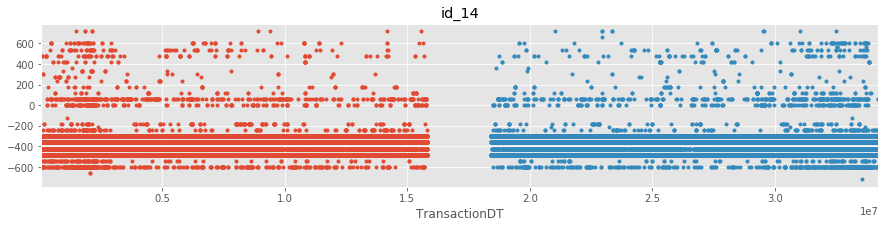

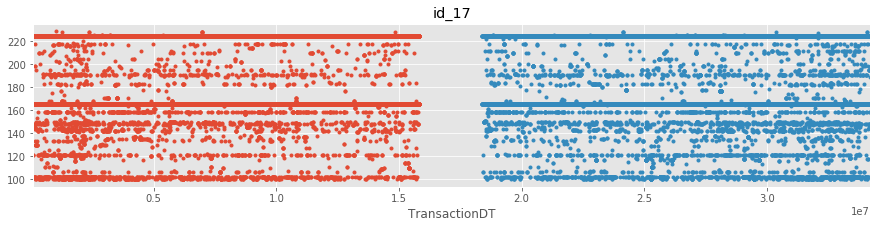

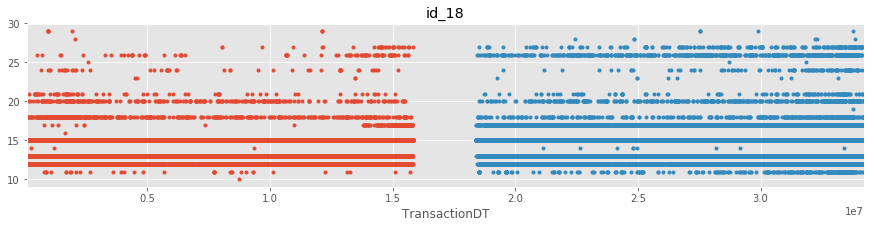

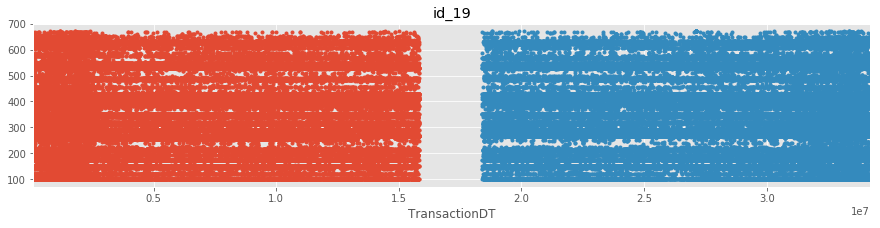

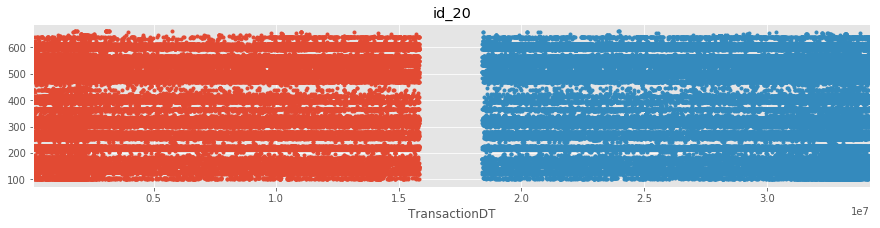

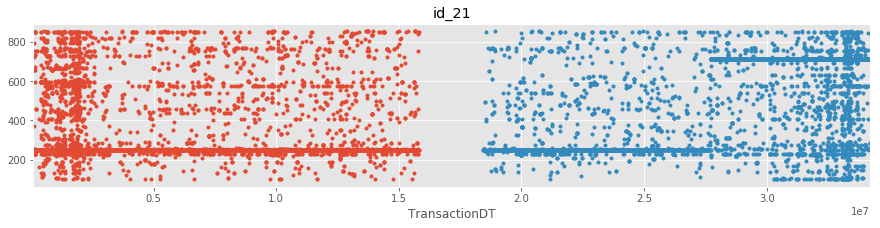

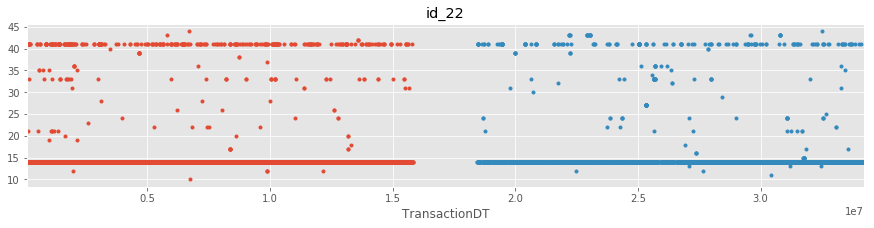

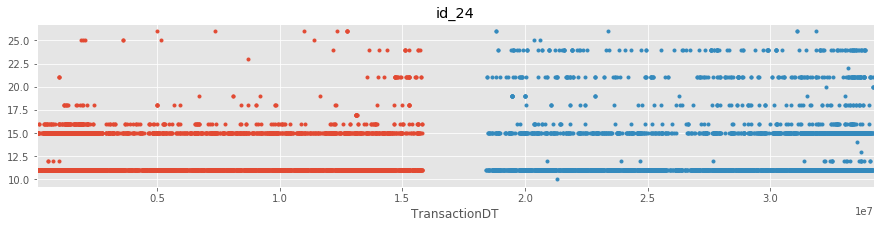

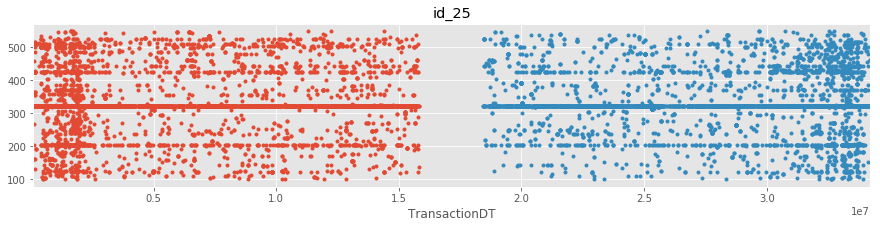

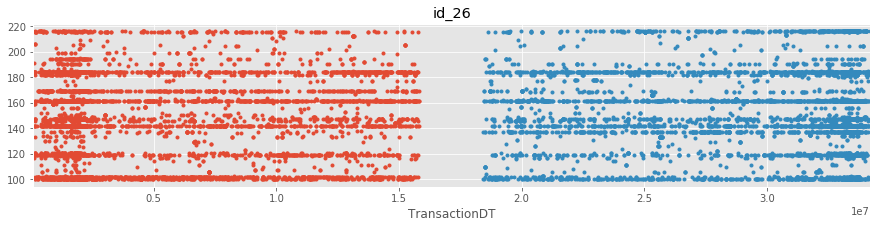

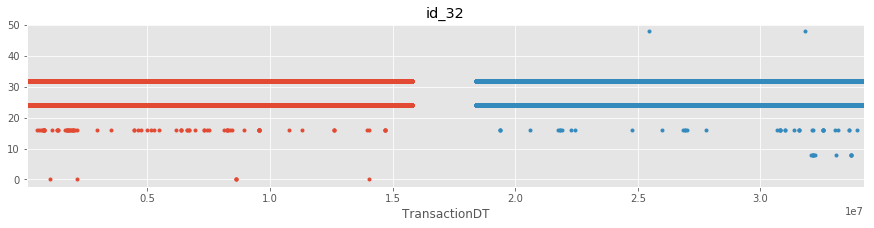

In [81]:
id_cols = [c for c in train.columns if 'id' in c]
for i in id_cols:
    try:
        train.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        test.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        plt.show()
    except TypeError:
        pass